#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 13
**CH11 Used cars**

using the used-cars dataset

version 0.8 2021-07-15

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from mizani.formatters import percent_format
from plotnine import *
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse, rmse

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/used-cars/clean/"
data_out = dirname + "da_case_studies/ch13-used-cars-reg/"
output = dirname + "da_case_studies/ch13-used-cars-reg/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
from py_helper_functions import *


In [4]:
# DATA IMPORT
data = pd.read_csv(data_in + "used-cars_2cities_prep.csv")


In [5]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["condition"] = data["condition"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")


In [6]:
# drop hybrid models then drop column
data = data.loc[data.Hybrid == 0].drop(["Hybrid"], axis=1)


In [7]:
# check frequency by fuel type
freq = data.groupby("fuel").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
fuel,,,
Missing,1,0.190,0.190
diesel,1,0.190,0.380
gas,516,98.099,98.479
hybrid,1,0.190,98.669
other,7,1.331,100.000


In [8]:
# keep gas-fuelled vehicles
data = data.loc[data.fuel == "gas"]


In [9]:
# check frequency by vehicle condition
freq = data.groupby("condition").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
condition,,,
Missing,207,40.116,40.116
excellent,133,25.775,65.891
fair,14,2.713,68.604
good,106,20.543,89.147
like new,53,10.271,99.418
new,3,0.581,99.999


In [10]:
# drop vehicles in fair and new condition, trucks
data = data.loc[~data.condition.isin(["new", "fair"])]

# drop unrealistic values for price and odometer reading
data = data.loc[(data.price >= 500) & (data.price <= 25000) & (data.odometer <= 100)]

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.loc[
    ~((data.price < 1000) & ((data.condition == "like new") | (data.age < 8)))
]


In [11]:
# check frequency by transmission
freq = data.groupby("transmission").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
transmission,,,
automatic,478,98.557,98.557
manual,7,1.443,100.000


In [12]:
data = data.loc[~(data.transmission == "manual")]


In [13]:
# check frequency by transmission
freq = data.groupby("type").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
type,,,
Missing,223,46.653,46.653
SUV,1,0.209,46.862
convertible,6,1.255,48.117
coupe,19,3.975,52.092
pickup,1,0.209,52.301
sedan,227,47.490,99.791
wagon,1,0.209,100.000


In [14]:
# drop if truck
data = data.loc[~(data.type == "truck")]
# drop pricestr
data = data.drop(["pricestr"], axis=1)


In [15]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 2


In [16]:
data.reset_index(drop=True).to_csv(data_out + "usedcars_work_py.csv", index=False)


In [17]:
data = pd.read_csv(data_out + "usedcars_work_py.csv")

# Frequency tables


In [18]:
# area
data.groupby("area").agg(frequency=("price", "size"), mean=("price", np.mean))


,frequency,mean
area,,
chicago,281,6060.975089
los angeles,197,5518.253807


In [19]:
# focus only on Chicago
data = data.loc[data.area == "chicago"]


In [20]:
# condition
data.groupby("condition").agg(frequency=("price", "size"), mean=("price", np.mean))


,frequency,mean
condition,,
Missing,124,6611.161290
excellent,75,6724.186667
good,67,3988.179104
like new,15,7455.200000


In [21]:
# drive
data.groupby("drive").agg(frequency=("price", "size"), mean=("price", np.mean))


,frequency,mean
drive,,
4wd,4,10168.750000
Missing,106,4575.094340
fwd,169,6893.485207
rwd,2,6250.000000


In [22]:
# dealer
data.groupby("dealer").agg(frequency=("price", "size"), mean=("price", np.mean))


,frequency,mean
dealer,,
0,193,4402.181347
1,88,9699.011364


In [23]:
# data summary
data.loc[
    :,
    [
        "age",
        "odometer",
        "LE",
        "XLE",
        "SE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "cylind6",
    ],
].describe()


,age,odometer,LE,XLE,SE,cond_likenew,cond_excellent,cond_good,cylind6
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,12.298932,12.521702,0.192171,0.071174,0.064057,0.053381,0.266904,0.238434,0.145907
std,5.892153,5.172572,0.394710,0.257575,0.245291,0.225193,0.443131,0.426886,0.353643
min,1.000000,0.231900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,8.140000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,13.655900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17.000000,16.430000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,27.000000,25.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
# Histograms not in the textbook


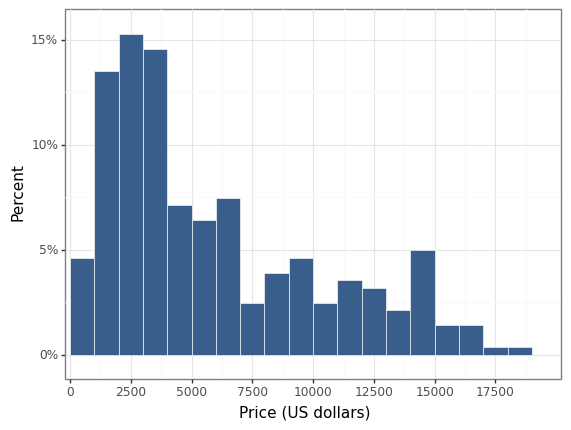

<ggplot: (380429755)>

In [25]:
(
    ggplot(data, aes(x="price"))
    + geom_histogram(
        aes(y="(stat(count))/sum(stat(count))"),
        binwidth=1000,
        boundary=0,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + coord_cartesian(xlim=(0, 20000))
    + labs(x="Price (US dollars)", y="Percent")
    + theme_bw()
    + expand_limits(x=0.01, y=0.01)
    + scale_y_continuous(expand=(0.01, 0.01), labels=percent_format())
    + scale_x_continuous(expand=(0.01, 0.01), breaks=seq(0, 20000, 2500))
)


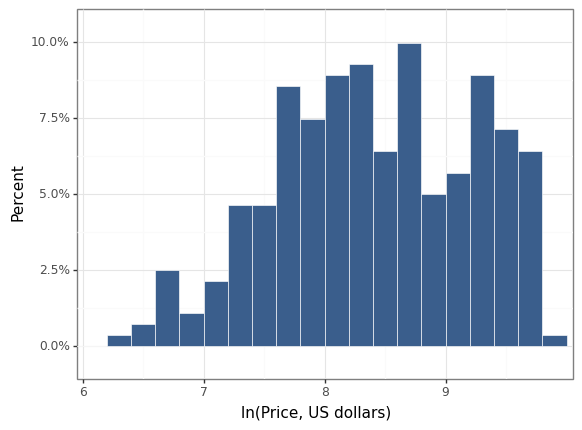

<ggplot: (380547494)>

In [26]:
(
    ggplot(data, aes(x="lnprice"))
    + geom_histogram(
        aes(y="(stat(count)) / sum(stat(count))"),
        binwidth=0.2,
        boundary=0,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + coord_cartesian(xlim=(6, 10))
    + labs(x="ln(Price, US dollars)", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_y_continuous(expand=(0.01, 0.01), labels=percent_format())
    + scale_x_continuous(expand=(0.01, 0.01), breaks=seq(6, 10, 1))
    + theme_bw()
)


### Regression analysis

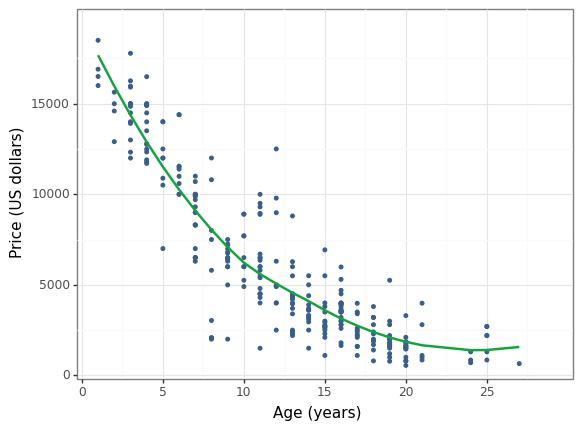

<ggplot: (380593402)>

In [27]:
# lowess
(
    ggplot(data, aes(x="age", y="price"))
    + geom_point(color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True)
    + geom_smooth(method="loess", se=False, colour=color[1], size=1, span=0.9)
    + labs(x="Age (years)", y="Price (US dollars)")
    + theme_bw()
    + expand_limits(x=0.01, y=0.01)
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, 5000)
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 30), breaks=seq(0, 30, 5))
)


In [28]:
data.describe()


,odometer,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE,cond_excellent,cond_good,cond_likenew,cylind6,agesq,agecu,odometersq
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000
mean,12.521702,0.313167,6060.975089,8.410963,2005.701068,12.298932,2.399433,0.192171,0.071174,0.064057,0.266904,0.238434,0.053381,0.145907,185.857651,3141.096085,183.453306
std,5.172572,0.464609,4490.818067,0.812821,5.892153,5.892153,0.590359,0.394710,0.257575,0.245291,0.443131,0.426886,0.225193,0.353643,150.578697,3504.795719,127.300387
min,0.231900,0.000000,550.000000,6.309918,1991.000000,1.000000,-1.461449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.053778
25%,8.140000,0.000000,2500.000000,7.824046,2001.000000,7.000000,2.096790,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,343.000000,66.259600
50%,13.655900,0.000000,4400.000000,8.389359,2005.000000,13.000000,2.614172,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,169.000000,2197.000000,186.483605
75%,16.430000,1.000000,8995.000000,9.104425,2011.000000,17.000000,2.799109,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,289.000000,4913.000000,269.944900
max,25.300000,1.000000,18495.000000,9.825255,2017.000000,27.000000,3.230804,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,729.000000,19683.000000,640.090000


In [29]:
###################################
# Linear regressions

# Model 1: Linear regression on age
reg1 = smf.ols("price ~ age + agesq", data=data).fit(cov_type="HC0")
reg2 = smf.ols("price ~ age + agesq + odometer", data=data).fit(cov_type="HC0")
reg3 = smf.ols(
    "price ~ age + agesq + odometer + odometersq + LE + cond_excellent + cond_good + dealer",
    data=data,
).fit(cov_type="HC0")
reg4 = smf.ols(
    "price ~ age + agesq + odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer",
    data=data,
).fit(cov_type="HC0")
reg5 = smf.ols(
    "price ~ age + agesq + odometer + odometersq + LE * age + XLE * age + SE * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age",
    data=data,
).fit(cov_type="HC0")


In [30]:
# from sklearn.metrics import mean_squared_error

models = [reg1, reg2, reg3, reg4, reg5]
robustcov_results = []

for model in models:
    result = model.get_robustcov_results(cov_type="HC1").summary()
    robustcov_results.append(result)
    print(result)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     1065.
Date:                Mon, 03 Oct 2022   Prob (F-statistic):          4.54e-131
Time:                        12:47:51   Log-Likelihood:                -2497.9
No. Observations:                 281   AIC:                             5002.
Df Residuals:                     278   BIC:                             5013.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.837e+04    353.534     51.948      0.0

In [31]:
stargazer.Stargazer([reg1])


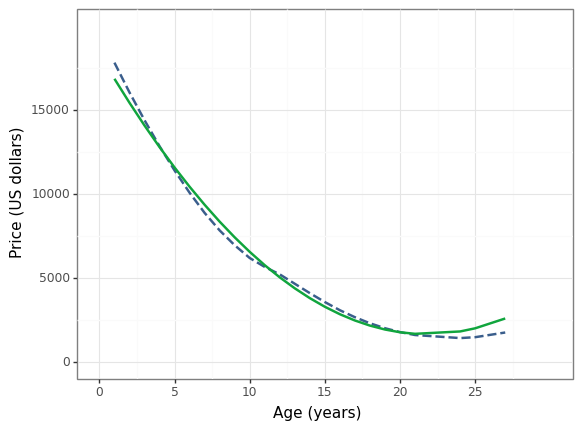

<ggplot: (380742994)>

In [32]:
(
    ggplot(data, aes(x="age"))
    + geom_smooth(
        aes(y="price"),
        colour=color[0],
        linetype="dashed",
        method="loess",
        se=False,
        size=1,
    )
    + geom_line(aes(y="reg1.predict()"), colour=color[1], size=1)
    + labs(x="Age (years)", y="Price (US dollars)")
    + scale_color_manual(
        name="",
        values=(color[0], color[1]),
        labels=("Lowess in age", "Quadratic in age"),
    )
    + theme_bw()
    + scale_x_continuous(limits=(0, 30), breaks=seq(0, 30, 5))
    + scale_y_continuous(limits=(0, 20000), breaks=seq(0, 20000, 5000))
    + theme(
        legend_position=(20, 20),
        legend_direction="horizontal",
        legend_background=element_blank(),
        legend_box_background=element_rect(color="white"),
    )
)


In [33]:
stargazer.Stargazer([reg1, reg2, reg3, reg4, reg5])


## Cross validation

In [34]:
from sklearn.model_selection import KFold

k = KFold(n_splits=4, shuffle=False, random_state=None)


In [35]:
### Cross validate OLS with combining sklearn k-fold cross validation and statsmodels ols formula


def cv_reg(formula, data, kfold, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]
        rmse_list += [rmse(data_train[formula.split("~")[0]], model.predict())]

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result


In [36]:
cv1 = cv_reg("price~age+agesq", data, k, "HC0")
cv2 = cv_reg("price~age+agesq+odometer", data, k, "HC0")
cv3 = cv_reg(
    "price~age+agesq+ odometer + odometersq + LE + cond_excellent + cond_good + dealer",
    data,
    k,
    "HC0",
)
cv4 = cv_reg(
    "price~age+agesq+ odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer",
    data,
    k,
    "HC0",
)
cv5 = cv_reg(
    "price~age+agesq + odometer + odometersq + LE*age + XLE*age + SE*age + cond_likenew*age + cond_excellent*age + cond_good*age + cylind6*age + odometer*age + dealer*age",
    data,
    k,
    "HC0",
)
cv_list = [cv1, cv2, cv3, cv4, cv5]


In [37]:
summarize_cv(cv_list)


,Model1,Model2,Model3,Model4,Model5
Fold1,1618.115827,1366.548420,1282.890143,1218.477533,1188.318586
Fold2,1811.811621,1449.936044,1338.341767,1273.860382,1242.693129
Fold3,1712.024549,1413.394587,1291.011447,1252.524381,1209.315131
Fold4,1826.251023,1450.552039,1312.096359,1267.679681,1208.683743
Average,1742.050755,1420.107772,1306.084929,1253.135494,1212.252647


### Prediction

In [38]:
data = data.loc[
    :,
    [
        "age",
        "agesq",
        "odometer",
        "odometersq",
        "SE",
        "LE",
        "XLE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "dealer",
        "price",
        "cylind6",
    ],
]


In [39]:
data.dtypes


age                 int64
agesq               int64
odometer          float64
odometersq        float64
SE                  int64
LE                  int64
XLE                 int64
cond_likenew        int64
cond_excellent      int64
cond_good           int64
dealer              int64
price               int64
cylind6             int64
dtype: object

In [40]:
new = pd.DataFrame(
    pd.Series(
        {
            "age": 10,
            "agesq": 10**2,
            "odometer": 12,
            "odometersq": 12**2,
            "SE": 0,
            "LE": 1,
            "XLE": 0,
            "cond_likenew": 0,
            "cond_excellent": 1,
            "cond_good": 0,
            "dealer": 0,
            "price": np.nan,
            "cylind6": 0,
        }
    )
).T
new


,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0


In [41]:
# turning off scientific notation
pd.set_option("display.float_format", lambda x: "%.3f" % x)


In [42]:
reg1.resid.describe()


count     281.000
mean        0.000
std      1758.313
min     -6367.827
25%      -863.663
50%      -101.332
75%       893.620
max      7448.668
dtype: float64

In [43]:
p1 = reg1.get_prediction(new).summary_frame()
p1


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,6569.387,155.912,6263.805,6874.968,3097.309,10041.464


In [44]:
(reg3.fittedvalues - data.price).describe()


count     281.000
mean        0.000
std      1325.029
min     -5782.218
25%      -584.509
50%        10.563
75%       628.288
max      4245.894
dtype: float64

In [45]:
p2 = reg3.get_prediction(new).summary_frame()
p2


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,6072.767,234.380,5613.391,6532.142,3398.099,8747.434


In [46]:
# get model3 rmse
rmse(reg3.fittedvalues, data.price)


1322.6687654317077

In [47]:
pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(95%)", "PI_high(95%)"],
        "Model1": p1[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model3": p2[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
    }
).set_index(" ")


,Model1,Model3
,,
Predicted,6569.387,6072.767
PI_low(95%),3097.309,3398.099
PI_high(95%),10041.464,8747.434


In [48]:
# summary of predictions and PI 80% version
p1 = reg1.get_prediction(new).summary_frame(alpha=0.2)
p2 = reg3.get_prediction(new).summary_frame(alpha=0.2)

pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(80%)", "PI_high(80%)"],
        "Model1": p1[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model3": p2[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
    }
).set_index(" ")


,Model1,Model3
,,
Predicted,6569.387,6072.767
PI_low(80%),4299.117,4323.896
PI_high(80%),8839.656,7821.637
